Требуется выполнить следующие действия с данными по облигациям на дату формирования данных:
1.	Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности. 
Предложить графическое представление полученных групп/кластеров. (график)
2.	По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица). 
3.	Допускается обоснованное изменение условий как по критериям оценки рынка, так с учетом выбранной стратегии инвестирования.

Пояснения:
	Для получения текущей даты можно использовать метод  datetime.date.today();
	Период расчета доходности рекомендуется выбирать 365 дней с текущей даты;
	Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ;
	Расчет доходности можно посмотреть, например, здесь.
(Доход) = (Цена облигации при продаже) + (НКД на момент продажи)
(Расходы) = (Цена облигации при покупке) + (НКД на момент покупки)+(Комиссии за приобретение, реализацию, хранение)
Комиссии Сбера зависят от тарифа, объема сделок и пр. Подробнее см. здесь.
В общем случае считаем налог доход при ставке НДФЛ 13% (при желании можно считать 15%) и комиссию брокера 0.06%
Комиссию Биржи принимаем в 0.0125%. 

Profit =  (((Цена_Номинальная  – Цена_покупки )*(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0)  –  НКД + 0.87*Купонный_доход_руб*X_лет)*100% )/((Цена_покупки+ НКД)*(1+Комиссия брокера в процентах/100 +Комиссия биржи/100))

	Период расчета НКД:  df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется выбирать меньше или равный  0.2. 
Если удовлетворяет условию, полученная величина умножается на COUPONPERCENT/COUPONFREQUENCY.
	Датасет содержит данные, которые нужно преобразовывать в форматы python, а также пустые и искаженные данные, с которыми тоже нужно что-то решить.


In [209]:

import pandas as pd

import io

import numpy as np

from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px

import requests
import lxml
import html5lib

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from scipy.spatial.distance import cdist


In [210]:
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [211]:
req = requests.get(bond_url).content
raw_data = pd.read_csv(io.StringIO(req.decode('cp1251')), sep=';', header= 1)

In [212]:
### Предобработка
print('Форма данных:', raw_data.shape[0], 'строк и',raw_data.shape[1],'полей')

Форма данных: 2668 строк и 54 полей


In [213]:
raw_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   2668 non-null   object 
 1   SHORTNAME               2668 non-null   object 
 2   NAME                    2668 non-null   object 
 3   TYPENAME                2668 non-null   object 
 4   ISIN                    2668 non-null   object 
 5   REGNUMBER               2285 non-null   object 
 6   LISTLEVEL               2397 non-null   float64
 7   FACEVALUE               2668 non-null   object 
 8   FACEUNIT                2668 non-null   object 
 9   ISSUESIZE               2646 non-null   float64
 10  IS_COLLATERAL           2668 non-null   int64  
 11  IS_EXTERNAL             2668 non-null   int64  
 12  PRIMARY_BOARDID         2668 non-null   object 
 13  PRIMARY_BOARD_TITLE     2668 non-null   object 
 14  MATDATE                 2616 non-null   

In [214]:
# Пропущенные наблюдения
raw_data.isna().sum().sort_values(ascending = False).head(10)

IS_RII        2654
SECSUBTYPE    2511
OFFERDATE     2220
DISCOUNT3     1792
LIMIT2        1792
DISCOUNT2     1792
LIMIT1        1792
YIELDATWAP    1538
DURATION      1089
REGNUMBER      383
dtype: int64

In [215]:
# Ищем дубликаты
print(f'Дубликаты: {raw_data.iloc[:,1:].duplicated().sum()}, ({np.round(100*raw_data.iloc[:,1:].duplicated().sum()/len(raw_data),1)}%)')

Дубликаты: 0, (0.0%)


In [216]:
### Исправляем данные

## str, object -> float
# Значение купона должно быть числовым с точкой (float), в наборе данных - str. Из-за запятой

raw_data['COUPONPERCENT'] = raw_data['COUPONPERCENT'].str.replace(',','.').apply(float)
raw_data['COUPONPERCENT'].describe

# FACEVALUE
raw_data['FACEVALUE'] = raw_data['FACEVALUE'].str.replace(',','.').apply(float)
raw_data['FACEVALUE'].describe
# INITIALFACEVALUE
raw_data['INITIALFACEVALUE'] = raw_data['INITIALFACEVALUE'].str.replace(',','.').apply(float)
raw_data['INITIALFACEVALUE'].describe
# PRICE
raw_data['PRICE'] = raw_data['PRICE'].str.replace(',','.').apply(float)
raw_data['PRICE'].describe
# PRICE_RUB
raw_data['PRICE_RUB'] = raw_data['PRICE_RUB'].str.replace(',','.').apply(float)
raw_data['PRICE_RUB'].describe
# COUPONVALUE
raw_data['COUPONVALUE'] = raw_data['COUPONVALUE'].str.replace(',','.').apply(float)
raw_data['COUPONVALUE'].describe


## str, object -> datetime

# ISSUEDATE
raw_data['ISSUEDATE'] = pd.to_datetime(raw_data['ISSUEDATE'],format='%d.%m.%Y')
raw_data['COUPONDATE'] = pd.to_datetime(raw_data['COUPONDATE'],format='%d.%m.%Y')
raw_data['OFFERDATE'] = pd.to_datetime(raw_data['OFFERDATE'],format='%Y-%m-%d')
raw_data['MATDATE'] = pd.to_datetime(raw_data['MATDATE'],format='%d.%m.%Y')
# STARTDATEMOEX # есть пропуски
raw_data['STARTDATEMOEX'] = pd.to_datetime(raw_data['STARTDATEMOEX'],format='%Y-%m-%d')

In [217]:
### Первый подход к расчёту доходности
new_data = raw_data.copy()
print('До очистки',new_data.shape)
### Заполнение логических пропусков
new_data['COUPONLENGTH'].fillna(np.divide(365,new_data['COUPONFREQUENCY']),inplace = True)
new_data['COUPONFREQUENCY'].fillna(np.divide(365,new_data['COUPONLENGTH']),inplace = True)
new_data['COUPONVALUE'].fillna(new_data['COUPONPERCENT']*new_data['FACEVALUE']/100, inplace = True)
new_data = new_data.dropna(subset = ['COUPONVALUE','COUPONDAYSPASSED','COUPONLENGTH','PRICE','FACEVALUE','ISIN','COUPONDATE','COUPONDAYSREMAIN','MATDATE','ISSUEDATE'])
print('После очистки', new_data.shape)
new_data['НКД'] = new_data['COUPONVALUE']*(np.divide(new_data['COUPONDAYSPASSED'],new_data['COUPONLENGTH']))
new_data['Годовой доход'] = (new_data['COUPONVALUE']*new_data['COUPONFREQUENCY'])*100 # в процентных пунктах!
new_data['Рыночная цена'] = new_data['PRICE']/100*new_data['FACEVALUE']
new_data[['ISIN','PRICE','FACEVALUE','COUPONDATE','COUPONDAYSPASSED','COUPONDAYSREMAIN']].head()
# Найдём исходную дату запроса - на случай технических проблем
check_date = ((new_data['COUPONDATE'][0])-timedelta(days=new_data['COUPONDAYSREMAIN'][0]))
# Нужно найти дату погашения или дату ближайшей оферты - смотря что ближе
for i in new_data.index:
    if new_data.loc[i,'OFFERDATE'] < new_data.loc[i,'MATDATE']:
        new_data.loc[i, 'Финальная дата'] = new_data.loc[i,'OFFERDATE']
    else:
        new_data.loc[i,'Финальная дата'] = new_data.loc[i,'MATDATE']


new_data['N оставшихся купонов'] = np.floor(np.divide((new_data['Финальная дата'] - check_date).astype('timedelta64[D]'),new_data['COUPONLENGTH']))
new_data['Валютный риск'] = 0

for i in new_data.index:
    if new_data.loc[i,'FACEUNIT'] != 'RUB':
        new_data.loc[i, 'Валютный риск'] = 1
new_data['Годовой купон в %'] = (new_data['COUPONVALUE']*(new_data['COUPONFREQUENCY']))/(new_data['FACEVALUE'])*100 # в процентных пунктах!
new_data['Лет до погашения'] = (new_data['Финальная дата'] - check_date).astype('timedelta64[M]')/12
new_data['Срочность инструмента'] = (new_data['Финальная дата'] - new_data['ISSUEDATE']).astype('timedelta64[M]')/12
mat_bins = [-np.inf,0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, np.inf]
new_data['Корзина остатка срочности'] = pd.cut(new_data['Лет до погашения'], mat_bins)
new_data['Корзина начальной срочности'] = pd.cut(new_data['Срочность инструмента'], mat_bins)
new_data = new_data[new_data['Финальная дата'] >= check_date]
new_data['Период НКД'] = new_data['COUPONDAYSPASSED']/new_data['COUPONLENGTH']
new_data['Переоценка в %'] = 100*(new_data['Рыночная цена']-new_data['FACEVALUE'])/new_data['FACEVALUE']

До очистки (2668, 54)
После очистки (2293, 54)


In [218]:
### Пишем функцию для расчёта доходности
# https://journal.open-broker.ru/investments/formula-dlya-rascheta-dohodnosti-obligacij-k-pogasheniyu/
### входные параметры:
# df
# nkd_col - поле с накопленным купонным доходом в dataframe, в абсолютном выражении
# coup_val_col - поле с купонными доходами в абсолютном выражении
# market_price_col - поле с текущей рыночной ценой облигации, в абсолютном выражении
# nom_col - поле со значением номинала, в абсолютном выражении
# broker_fee_rate - ставка комиссии брокера, в процентах
# ex_fee_rate  - ставка комиссии биржи, в процентах
# tax_rate - ставка налога, в десятичных долях
# coupons_n_col - количество оставшихся купонов, в штуках
# final_date_col - дата оферты или погашения бумаги
def calc_bond_yield(
    df,
    nkd_col,
    coup_val_col,
    market_price_col,
    nom_col,
    coupons_n_col,
    broker_fee_rate,
    ex_fee_rate,
    tax_rate,
    final_date_col,
    check_date
    ):
    df['REALBONDYIELD'] = 0
    for i in df.index:
        if (df.loc[i,nom_col]>df.loc[i,market_price_col]):
            df.loc[i,'REALBONDYIELD'] = 100*np.divide(np.divide(((
                df.loc[i, nom_col] - df.loc[i, market_price_col])*(1-tax_rate) - df.loc[i,nkd_col] + (
                (1-tax_rate)*df.loc[i,coup_val_col]*(df.loc[i,coupons_n_col])    
                )),(
                    df.loc[i,market_price_col]+df.loc[i,nkd_col])*(1+broker_fee_rate/100+ex_fee_rate/100
                )),(df.loc[i,final_date_col] - check_date).days/365)
        else:
            df.loc[i,'REALBONDYIELD'] = 100*np.divide(np.divide(((
                df.loc[i, nom_col] - df.loc[i, market_price_col]) - df.loc[i,nkd_col] + (
                (1-tax_rate)*df.loc[i,coup_val_col]*df.loc[i,coupons_n_col]    
                )),(
                    df.loc[i,market_price_col]+df.loc[i,nkd_col])*(1+(broker_fee_rate/100)+(ex_fee_rate/100)
                )),(df.loc[i,final_date_col] - check_date).days/365)

In [219]:
calc_bond_yield(
    df = new_data, 
    nkd_col = 'НКД',
    coup_val_col = 'COUPONVALUE',
    market_price_col = 'Рыночная цена',
    nom_col = 'FACEVALUE',
    coupons_n_col = 'N оставшихся купонов',
    broker_fee_rate = 0.06,
    ex_fee_rate = 0.0125,
    tax_rate = 0.13,
    final_date_col = 'Финальная дата',
    check_date = check_date
    )

count    2293.000000
mean        6.423426
std         5.550306
min         0.000000
25%         3.000000
50%         4.916667
75%         6.916667
max        91.083333
Name: Срочность инструмента, dtype: float64


Text(0, 0.5, 'N выпусков')

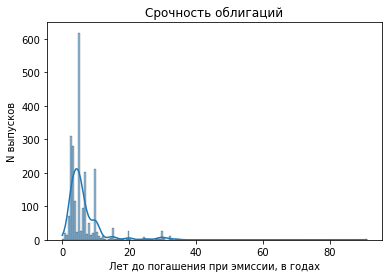

In [220]:
# На какой срок выпускали бумаги?
print(new_data['Срочность инструмента'].describe())
fig = sns.histplot(new_data, x = 'Срочность инструмента', kde = True)
plt.title('Срочность облигаций')
plt.xlabel('Лет до погашения при эмиссии, в годах')
plt.ylabel('N выпусков')


count    2293.000000
mean        3.211441
std         4.598879
min         0.000000
25%         0.916667
50%         2.166667
75%         3.583333
max        88.250000
Name: Лет до погашения, dtype: float64


Text(0, 0.5, 'N выпусков')

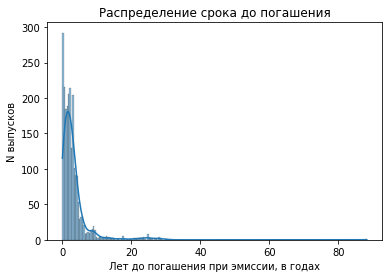

In [221]:
# Сколько осталось до погашения?
print(new_data['Лет до погашения'].describe())
fig = sns.histplot(new_data, x = 'Лет до погашения', kde = True)
plt.title('Распределение срока до погашения')
plt.xlabel('Лет до погашения при эмиссии, в годах')
plt.ylabel('N выпусков')


count    2293.000000
mean        6.667968
std         5.104323
min         0.000100
25%         1.349961
50%         7.180000
75%         9.474000
max        45.014000
Name: Годовой купон в %, dtype: float64


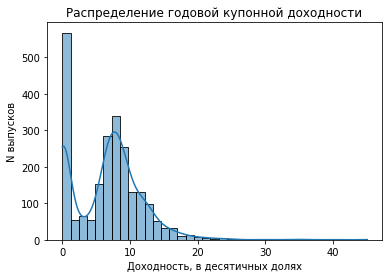

In [222]:
# Как распределена Годовой купон в %?
fig = sns.histplot(new_data, x = 'Годовой купон в %', kde = True)
plt.title('Распределение годовой купонной доходности')
plt.xlabel('Доходность, в десятичных долях')
plt.ylabel('N выпусков')
print(new_data['Годовой купон в %'].describe())

<AxesSubplot:xlabel='Лет до погашения', ylabel='Годовой купон в %'>

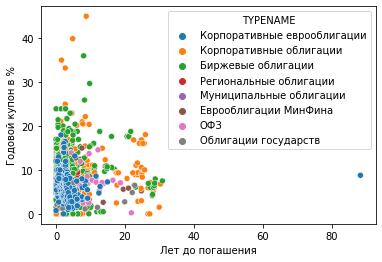

In [223]:
# Распределение облигаций по доходности и сроку погашения

sns.scatterplot(data = new_data, 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME')

   Дата записи Контрольное время  Срочность  Значение КБД
0   2022-09-09          18:39:57       0.25        7.5867
1   2022-09-09          18:39:57       0.50        7.5920
2   2022-09-09          18:39:57       0.75        7.6066
3   2022-09-09          18:39:57       1.00        7.6282
4   2022-09-09          18:39:57       2.00        7.7654
5   2022-09-09          18:39:57       3.00        7.9519
6   2022-09-09          18:39:57       5.00        8.3553
7   2022-09-09          18:39:57       7.00        8.6999
8   2022-09-09          18:39:57      10.00        9.0549
9   2022-09-09          18:39:57      15.00        9.3363
10  2022-09-09          18:39:57      20.00        9.4755
11  2022-09-09          18:39:57      30.00        9.6386


Text(0.5, 0, 'Лет до погашения, в годах')

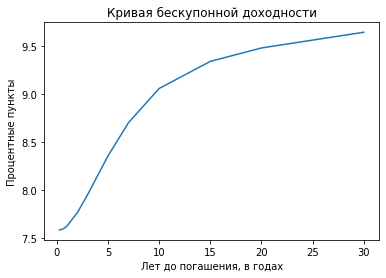

In [224]:
### Добавляем КБД
url = ('http://iss.moex.com/iss/engines/stock/zcyc.csv?iss.only=yearyields')

zcyc_data = requests.get(url).content
zcyc_data = pd.read_csv(io.StringIO(zcyc_data.decode('UTF-8')), sep = ';', header= 1)
zcyc_data.columns = ['Дата записи','Контрольное время', 'Срочность', 'Значение КБД']
print(zcyc_data)

plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'])
plt.title('Кривая бескупонной доходности')
plt.ylabel('Процентные пункты')
plt.xlabel('Лет до погашения, в годах')

In [225]:
def zcyc_match(df,zcyc_df, mat_column):
    for i in df.index:
        for j in range(len(zcyc_df)-1):
            if (df.loc[i,mat_column] > zcyc_df.loc[j,'Срочность']) & (df.loc[i,mat_column] <= zcyc_df.loc[j+1,'Срочность']):
                df.loc[i,'КБД'] = zcyc_df.loc[j,'Значение КБД']

In [226]:
zcyc_match(new_data,zcyc_data,'Лет до погашения')

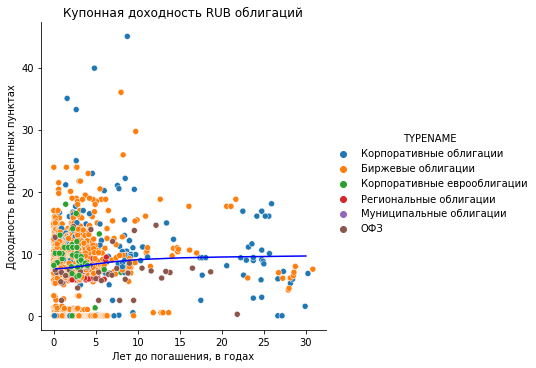

       Годовой купон в %  Лет до погашения
count        2027.000000       2027.000000
mean            6.889685          3.108781
std             5.303537          4.275316
min             0.000100          0.000000
25%             0.509990          0.916667
50%             7.577143          2.166667
75%             9.795356          3.416667
max            45.014000         30.833333


In [228]:
# RUB облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'RUB'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.ylabel('Доходность в процентных пунктах')
plt.xlabel('Лет до погашения, в годах')
plt.title('Купонная доходность RUB облигаций')
plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], color = 'b', label = 'КБД')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'RUB'][['Годовой купон в %','Лет до погашения']].describe())

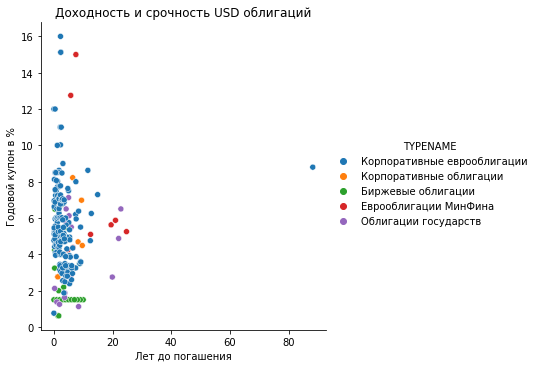

       Годовой купон в %  Лет до погашения
count         222.000000        222.000000
mean            5.307126          4.120120
std             2.649992          6.992977
min             0.614946          0.000000
25%             3.460000          1.270833
50%             5.058300          2.541667
75%             6.599100          4.750000
max            16.000000         88.250000


In [230]:
# Долларовые облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'USD'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность USD облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'USD'][['Годовой купон в %','Лет до погашения']].describe())

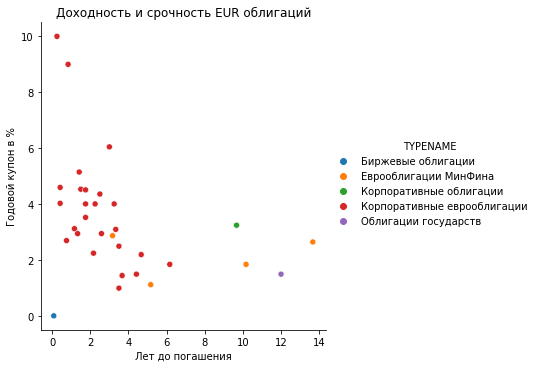

       Годовой купон в %  Лет до погашения
count          32.000000         32.000000
mean            3.395030          3.507812
std             2.088287          3.405033
min             0.010000          0.083333
25%             2.112500          1.395833
50%             3.025000          2.541667
75%             4.115000          3.854167
max            10.000000         13.666667


In [231]:
# Евро облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'EUR'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность EUR облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'EUR'][['Годовой купон в %','Лет до погашения']].describe())

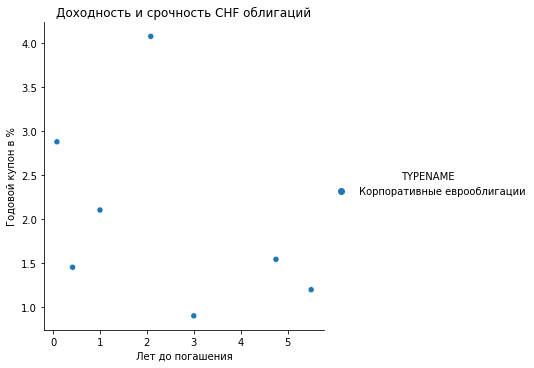

       Годовой купон в %  Лет до погашения
count           7.000000          7.000000
mean            2.018657          2.404762
std             1.113956          2.115545
min             0.898000          0.083333
25%             1.322500          0.708333
50%             1.540000          2.083333
75%             2.487500          3.875000
max             4.072600          5.500000


In [232]:
# CHF облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'CHF'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность CHF облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'CHF'][['Годовой купон в %','Лет до погашения']].describe())

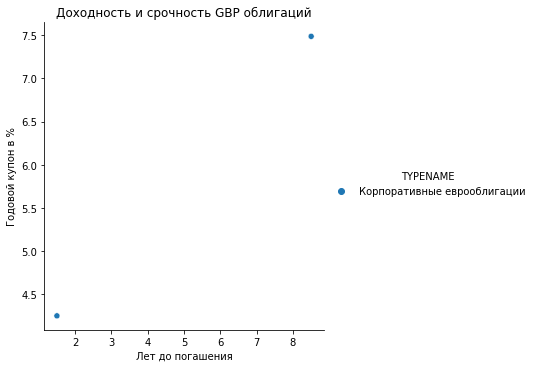

       Годовой купон в %  Лет до погашения
count           2.000000          2.000000
mean            5.868500          5.000000
std             2.288905          4.949747
min             4.250000          1.500000
25%             5.059250          3.250000
50%             5.868500          5.000000
75%             6.677750          6.750000
max             7.487000          8.500000


In [233]:
# GBP облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'GBP'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность GBP облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'GBP'][['Годовой купон в %','Лет до погашения']].describe())

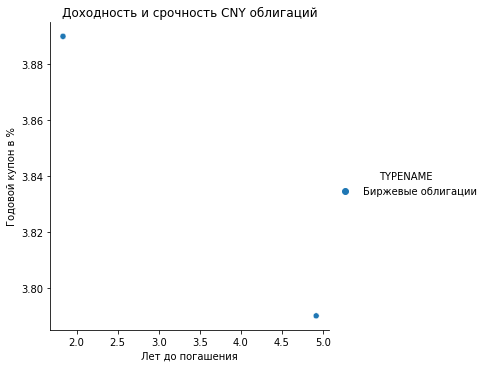

       Годовой купон в %  Лет до погашения
count           3.000000          3.000000
mean            3.856667          2.861111
std             0.057735          1.780163
min             3.790000          1.833333
25%             3.840000          1.833333
50%             3.890000          1.833333
75%             3.890000          3.375000
max             3.890000          4.916667


In [234]:
# CNY облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'CNY'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность CNY облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'CNY'][['Годовой купон в %','Лет до погашения']].describe())

In [235]:
pd.pivot_table(new_data, values = 'SECID', index = 'TYPENAME', columns = 'FACEUNIT', aggfunc = 'count')

FACEUNIT,CHF,CNY,EUR,GBP,RUB,USD
TYPENAME,,,,,,
Биржевые облигации,NaN,3.0,1.0,NaN,1575.0,28.0
Еврооблигации МинФина,NaN,NaN,4.0,NaN,NaN,10.0
Корпоративные еврооблигации,7.0,NaN,25.0,2.0,60.0,161.0
Корпоративные облигации,NaN,NaN,1.0,NaN,226.0,8.0
Муниципальные облигации,NaN,NaN,NaN,NaN,9.0,NaN
ОФЗ,NaN,NaN,NaN,NaN,44.0,NaN
Облигации государств,NaN,NaN,1.0,NaN,NaN,15.0
Региональные облигации,NaN,NaN,NaN,NaN,113.0,NaN


In [273]:
### Ищем кластеры - по валютам!
clusters_data = new_data[['SECID','Годовой купон в %','N оставшихся купонов','Лет до погашения','Срочность инструмента','Переоценка в %','REALBONDYIELD','Риск-премия']][new_data['FACEUNIT'] == 'RUB']
clusters_data = clusters_data.set_index('SECID')
clusters_data.dropna(inplace= True)
kmeans = KMeans(n_clusters = 4, random_state = 1481).fit_predict(clusters_data)


In [275]:
clusters_data

,Годовой купон в %,N оставшихся купонов,Лет до погашения,Срочность инструмента,Переоценка в %,REALBONDYIELD,Риск-премия
SECID,,,,,,,
RU000A0JQ5C5,5.000010,0.0,6.583333,19.916667,0.00,-6.009310,-14.364610
RU000A0JQ7Z2,7.828000,3.0,1.750000,14.916667,-0.38,5.002975,-2.625225
RU000A0JQAL8,16.636000,1.0,0.666667,13.666667,2.37,-0.641245,-8.233245
RU000A0JQAM6,20.164000,11.0,6.000000,19.000000,9.97,10.631737,2.276437
RU000A0JQRD9,7.828000,4.0,2.333333,14.916667,-0.32,5.394036,-2.371364
...,...,...,...,...,...,...,...
XS2318748956,7.450000,11.0,6.000000,7.500000,-6.79,6.508771,-1.846529
XS2321680998,8.476712,7.0,3.750000,5.250000,-7.73,8.628049,0.676149
XS2343532508,8.125000,7.0,4.000000,4.916667,0.00,4.978420,-2.973480


In [237]:
### Показываем кластеры

Часть вторая: отбор оптимальных облигаций

In [259]:
### Отбираем низкий риск
## Первый котировальный список
## Валюта - строго RUB
## SECSUBTYPE - пропуск, т.к. сложные продукты
## HIGH_RISK == 0
## IS_QUALIFIED_INVESTORS == 0
## Премия от КБД > 0 и < 5 п.п.

new_data['Риск-премия'] = new_data['REALBONDYIELD'] - new_data['КБД']
final_data = new_data[new_data['Период НКД'] >= 0.2]
final_data = final_data[
    (new_data['FACEUNIT']=='RUB')&
    (new_data['HIGH_RISK']==0)&
    (new_data['SECSUBTYPE'].isna())&
    (new_data['IS_QUALIFIED_INVESTORS'] == 0)&
    (new_data['REALBONDYIELD']>0)&
    (abs(new_data['Переоценка в %'])<=10)&
    (new_data['Риск-премия']>0)&
    (new_data['Риск-премия']<0.5*new_data['КБД'])]
final_data = final_data[['SECID','TYPENAME','Лет до погашения','REALBONDYIELD','Финальная дата','FACEVALUE','Рыночная цена','Переоценка в %','COUPONVALUE','Годовой купон в %','НКД','КБД','Риск-премия']]
final_data.sort_values(by = 'REALBONDYIELD',ascending=False).head(10)

C:\Users\mikha\AppData\Local\Temp\ipykernel_16608\1346179119.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_data = final_data[


,SECID,TYPENAME,Лет до погашения,REALBONDYIELD,Финальная дата,FACEVALUE,Рыночная цена,Переоценка в %,COUPONVALUE,Годовой купон в %,НКД,КБД,Риск-премия
93,RU000A0JUAN6,Биржевые облигации,21.083333,14.194771,2043-10-21,1000.0,999.8000,-0.02,88.21,17.642000,55.737088,9.4755,4.719271
710,RU000A1008Y3,Биржевые облигации,6.500000,12.404537,2029-03-27,1000.0,1006.9000,0.69,84.77,16.954000,73.591538,8.3553,4.049237
2165,RU000A104U68,Биржевые облигации,9.666667,12.030011,2032-05-14,1000.0,1000.0000,0.00,76.34,15.268000,44.461758,8.6999,3.330111
2111,RU000A104EP6,Биржевые облигации,4.250000,11.468297,2026-12-22,1000.0,1027.4000,2.74,12.12,14.544000,10.504000,7.9519,3.516397
1845,RU000A103JR3,Биржевые облигации,1.916667,11.375471,2024-08-12,1000.0,938.3000,-6.17,26.43,10.572000,7.551429,7.6282,3.747271
889,RU000A101327,Биржевые облигации,0.666667,11.304849,2023-05-22,1000.0,916.7000,-8.33,0.35,0.009996,0.280438,7.5920,3.712849
2082,RU000A104B04,Биржевые облигации,4.166667,11.286612,2026-11-26,972.0,968.8896,-0.32,10.59,13.074074,7.766000,7.9519,3.334712
910,RU000A1014V7,Биржевые облигации,1.166667,11.208058,2023-11-13,5000.0,4996.0000,-0.08,57.53,13.807200,40.271000,7.6282,3.579858
220,RU000A0JVXS5,Биржевые облигации,3.083333,11.095191,2025-10-30,1000.0,1010.0000,1.00,84.77,16.954000,59.618462,7.9519,3.143291
2016,RU000A1043B8,Биржевые облигации,2.666667,11.022312,2025-05-19,1000.0,979.8000,-2.02,32.41,12.964000,6.766923,7.7654,3.256912


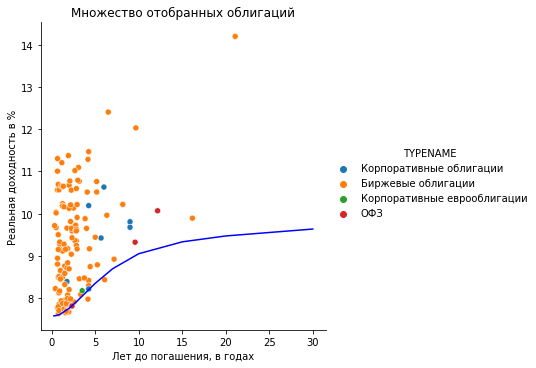

       REALBONDYIELD  Лет до погашения
count     132.000000        132.000000
mean        9.349752          2.878157
std         1.187237          2.923799
min         7.635529          0.333333
25%         8.417417          1.229167
50%         9.305328          2.000000
75%        10.183926          3.375000
max        14.194771         21.083333


In [260]:
sns.relplot(data = final_data, 
x = 'Лет до погашения', 
y = 'REALBONDYIELD',
hue = 'TYPENAME',
legend = 'full'
)
plt.ylabel('Реальная доходность в %')
plt.xlabel('Лет до погашения, в годах')
plt.title('Множество отобранных облигаций')
plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], color = 'b', label = 'КБД')
plt.show()
print(final_data[['REALBONDYIELD','Лет до погашения']].describe())

In [240]:
top_10_bonds = final_data.sort_values(by = 'REALBONDYIELD',ascending=False).head(10)
top_10_bonds

,SECID,TYPENAME,Лет до погашения,REALBONDYIELD,Финальная дата,FACEVALUE,Рыночная цена,Переоценка в %,COUPONVALUE,Годовой купон в %,НКД,Корзина остатка срочности
899,RU000A1013Z0,Биржевые облигации,0.166667,21.145282,2022-11-28,1000.0,949.9,-5.01,0.10,0.010,0.078297,"(-inf, 0.25]"
870,RU000A1010V5,Биржевые облигации,0.166667,20.810542,2022-11-24,1000.0,952.8,-4.72,0.30,0.010,0.279452,"(-inf, 0.25]"
1541,RU000A102LF6,Биржевые облигации,8.250000,20.693257,2030-12-13,1000.0,999.7,-0.03,64.82,25.928,55.560000,"(7.0, 10.0]"
171,RU000A0JVBX1,Биржевые облигации,0.000000,19.144204,2022-10-03,1000.0,985.8,-1.42,0.50,0.100,0.447802,"(-inf, 0.25]"
2162,RU000A104TM1,Биржевые облигации,2.666667,17.735815,2025-05-15,1000.0,1015.4,1.54,59.84,23.936,15.124396,"(2.0, 3.0]"
100,RU000A0JUCG6,Биржевые облигации,6.166667,17.045923,2028-11-29,1000.0,906.0,-9.40,93.89,18.778,48.492637,"(5.0, 7.0]"
945,RU000A1017Z1,Биржевые облигации,0.250000,16.661919,2022-12-19,1000.0,949.8,-5.02,0.30,0.010,0.272603,"(-inf, 0.25]"
70,RU000A0JTZM7,Биржевые облигации,5.666667,16.606872,2028-06-08,1000.0,921.4,-7.86,93.89,18.778,44.365604,"(5.0, 7.0]"
179,RU000A0JVF98,Корпоративные облигации,7.583333,16.514641,2030-05-10,1000.0,1004.3,0.43,52.50,21.000,41.086957,"(7.0, 10.0]"
186,RU000A0JVLA8,Корпоративные облигации,7.750000,16.290521,2030-06-19,1000.0,989.9,-1.01,51.24,20.496,40.100870,"(7.0, 10.0]"


In [261]:
top_1q_bonds = final_data[final_data['Лет до погашения'] <= 0.25]
top_h_bonds = final_data[(final_data['Лет до погашения'] <= 0.5)&(final_data['Лет до погашения'] > 0.25)]
top_3q_bonds = final_data[(final_data['Лет до погашения'] <= 0.75)&(final_data['Лет до погашения'] > 0.5)]
top_1y_bonds = final_data[(final_data['Лет до погашения'] <= 1)&(final_data['Лет до погашения'] > 0.75)]
top_2y_bonds = final_data[(final_data['Лет до погашения'] <= 2)&(final_data['Лет до погашения'] > 1)]
top_3y_bonds = final_data[(final_data['Лет до погашения'] <= 3)&(final_data['Лет до погашения'] > 2)]
top_5y_bonds = final_data[(final_data['Лет до погашения'] <= 5)&(final_data['Лет до погашения'] > 3)]
top_7y_bonds = final_data[(final_data['Лет до погашения'] <= 7)&(final_data['Лет до погашения'] > 5)]
top_10y_bonds = final_data[(final_data['Лет до погашения'] <= 10)&(final_data['Лет до погашения'] > 7)]
top_15y_bonds = final_data[(final_data['Лет до погашения'] <= 15)&(final_data['Лет до погашения'] > 10)]
top_20y_bonds = final_data[(final_data['Лет до погашения'] <= 20)&(final_data['Лет до погашения'] > 15)]
top_30y_bonds = final_data[(final_data['Лет до погашения'] <= 30)&(final_data['Лет до погашения'] > 20)]